# Figure S12 E-I

***NOTE***: This is the same notebook for **Figure 3M**, which is a feature panel, fully displayed in **FigureS12**.

### Import packages

In [1]:
import scdiffeq as sdq
import scdiffeq_analyses as sdq_an
import pandas as pd
import cellplots as cp
import matplotlib.pyplot as plt

### Load project

In [2]:
project = sdq.io.Project("./LightningSDE-FixedPotential-RegularizedVelocityRatio/")

### Organize loss values

In [3]:
SummarizedLoss = {}
for vname, version_path in project._VERSION_PATHS.items():
    version = getattr(project, vname)
    SummarizedLoss[vname] = sdq_an.parsers.SummarizedLoss(version=version)

### Define function for the `velocity_stream` plot

In [4]:
def pub_plot(adata, summarized_loss):

    version = summarized_loss._version._NAME
    v_int = int(version.split("_")[-1])

    fig, axes = cp.plot(1, 1, width=1.4, del_xy_ticks=[True], delete="all")
    axes = cp.umap_manifold(
        adata,
        groupby="clusters",
        c_background=clust_cmap,
        s_background=350,
        s_cover=200,
        ax=axes[0],
    )
    best_epoch = summarized_loss.best_epoch
    savename = f"seed_{v_int}.best_val_ckpt.epoch_{best_epoch}"
    _ = sdq.pl.velocity_stream(
        adata,
        ax=axes[0],
        c="diffusion", scatter_kwargs={"cmap": "plasma_r"},
        scatter_zorder=101,
        stream_zorder=110,
        return_axes=True,
        cutoff_percentile=0.01,
        save=False,
        svg_dpi=500,
#         cmap="plasma_r"
    )
    title = f"Seed: {v_int} | Best validation epoch: {best_epoch}"
    axes[0].set_title(title)
    plt.savefig(f"{savename}.svg", dpi=300)
    plt.savefig(f"{savename}.png", dpi=300)
    plt.show()

### Load data

In [5]:
adata = sdq.io.read_h5ad("./data/Pancreas/endocrinogenesis_day15.h5ad")

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'h5ad_path'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'


### Compute pseudotime, bin

In [6]:
adata = sdq_an.tl.compute_CytoTRACE_pseudotime(adata)

Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:07) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [7]:
sdq_an.tl.bin_pseudotime(adata, pseudotime_key="ct_pseudotime", n_bins=10)

### Prepare data for plotting

In [8]:
adata_pl = adata.copy()
adata_pl.obs["t"] = pd.Categorical(adata_pl.obs["t"])
clusters = adata.obs["clusters"].unique().sort_values()
clust_cmap = {i: j for i, j in zip(clusters, adata.uns["clusters_colors"])}
adata_pl.obs['t'] = adata_pl.obs['t'].cat.as_ordered()

### Define a helper class for compatibility

In [9]:
class Model:
    def __init__(self, ckpt_path):
        self._ckpt_path = ckpt_path
    @property
    def DiffEq(self):
        return sdq.io.load_diffeq(self._ckpt_path)

### For each training run, plot the best `ckpt` 

 - [INFO] | Added: adata.obsm['X_drift']
 - [INFO] | Added: adata.obsm['drift']
 - [INFO] | Added: adata.obsm['X_diffusion']
 - [INFO] | Added: adata.obsm['diffusion']
 - [INFO] | Added: adata.obsp['velocity_graph']
 - [INFO] | Added: adata.obsp['velocity_graph_neg']


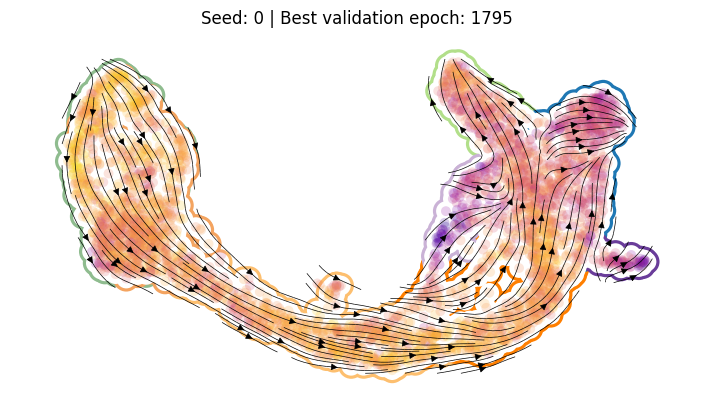

 - [INFO] | Updated: adata.obsm['X_drift']
 - [INFO] | Updated: adata.obsm['drift']
 - [INFO] | Updated: adata.obsm['X_diffusion']
 - [INFO] | Updated: adata.obsm['diffusion']
 - [INFO] | Updated: adata.obsp['velocity_graph']
 - [INFO] | Updated: adata.obsp['velocity_graph_neg']


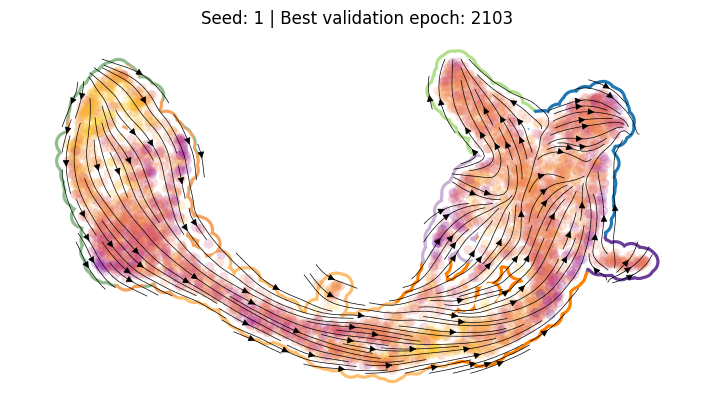

 - [INFO] | Updated: adata.obsm['X_drift']
 - [INFO] | Updated: adata.obsm['drift']
 - [INFO] | Updated: adata.obsm['X_diffusion']
 - [INFO] | Updated: adata.obsm['diffusion']
 - [INFO] | Updated: adata.obsp['velocity_graph']
 - [INFO] | Updated: adata.obsp['velocity_graph_neg']


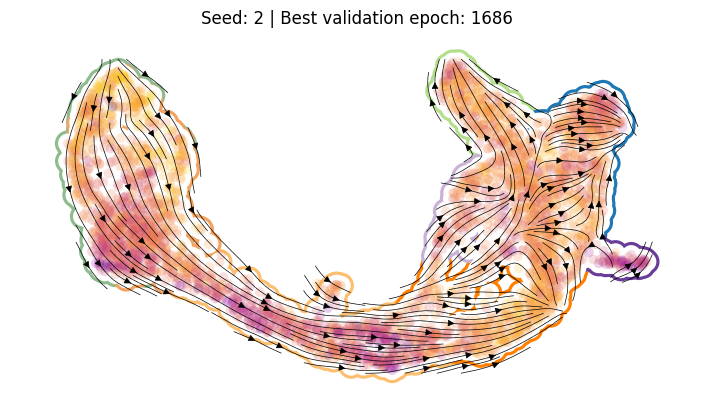

 - [INFO] | Updated: adata.obsm['X_drift']
 - [INFO] | Updated: adata.obsm['drift']
 - [INFO] | Updated: adata.obsm['X_diffusion']
 - [INFO] | Updated: adata.obsm['diffusion']
 - [INFO] | Updated: adata.obsp['velocity_graph']
 - [INFO] | Updated: adata.obsp['velocity_graph_neg']


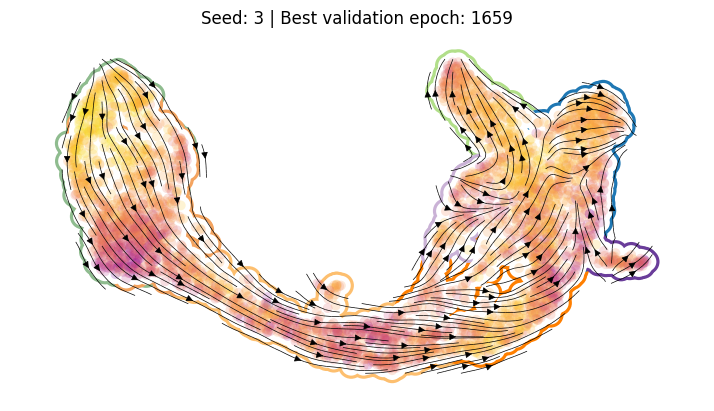

 - [INFO] | Updated: adata.obsm['X_drift']
 - [INFO] | Updated: adata.obsm['drift']
 - [INFO] | Updated: adata.obsm['X_diffusion']
 - [INFO] | Updated: adata.obsm['diffusion']
 - [INFO] | Updated: adata.obsp['velocity_graph']
 - [INFO] | Updated: adata.obsp['velocity_graph_neg']


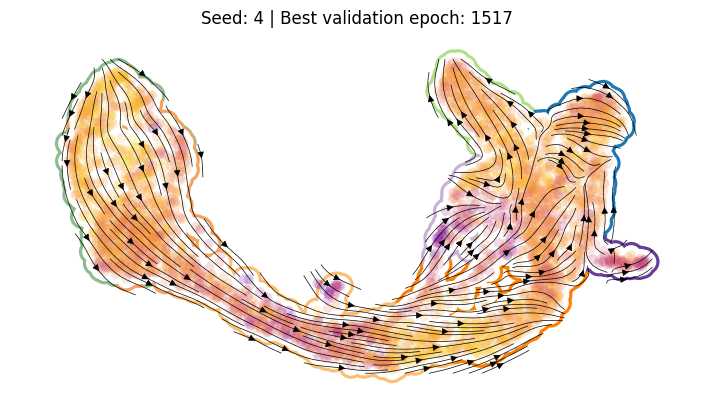

In [10]:
for en, (ver, summarized_loss) in enumerate(SummarizedLoss.items()):
    ckpt_path = summarized_loss.best_ckpt.path
    model = Model(ckpt_path = ckpt_path)
    sdq.tl.drift(adata=adata_pl, model=model)
    sdq.tl.diffusion(adata=adata_pl, model=model)
    sdq.tl.velocity_graph(adata_pl)
    pub_plot(adata_pl, summarized_loss)